### Задание 1

Подготовить данные для модели:
    
   Анализ данных, необходимые корректировки. 
1. Обработать пропуски. 
2. Оценить выбросы. 
3. Корреляция. 
4. Тест на нормальность распределения.
5. Масштабировать данные.

Загрузим данные и посмотрим что они из себя представляют

In [10]:
import pandas as pd
credit_train_df = pd.read_csv('credit_train.csv', encoding='WINDOWS-1251', on_bad_lines='skip', sep=';', decimal=',')
print(credit_train_df.head())
print("\nКоличество строк и столбцов:")
print(credit_train_df.shape)

   client_id gender   age marital_status job_position  credit_sum  \
0          1      M   NaN            NaN          UMN    59998.00   
1          2      F   NaN            MAR          UMN    10889.00   
2          3      M  32.0            MAR          SPC    10728.00   
3          4      F  27.0            NaN          SPC    12009.09   
4          5      M  45.0            NaN          SPC         NaN   

   credit_month tariff_id  score_shk education        living_region  \
0            10       1.6        NaN       GRD   КРАСНОДАРСКИЙ КРАЙ   
1             6       1.1        NaN       NaN               МОСКВА   
2            12       1.1        NaN       NaN      ОБЛ САРАТОВСКАЯ   
3            12       1.1        NaN       NaN    ОБЛ ВОЛГОГРАДСКАЯ   
4            10       1.1   0.421385       SCH  ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   

   monthly_income  credit_count  overdue_credit_count  open_account_flg  
0         30000.0           1.0                   1.0                 0  
1         

In [11]:
print(credit_train_df.isnull().sum())

client_id                  0
gender                     0
age                        3
marital_status             3
job_position               0
credit_sum                 2
credit_month               0
tariff_id                  0
score_shk                  7
education                  5
living_region            192
monthly_income             5
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64


Как видно даже на первых 4 результатах данные очень плохие. Есть пропуски и несогласованность данных. Удалим все строки где есть пропуски. Как будет видно далее их чуть более 5%, что не критично.

In [12]:
credit_train_df = credit_train_df.dropna()
print("\nКоличество строк и столбцов:")
print(credit_train_df.shape)


Количество строк и столбцов:
(161331, 15)


Для нашего эксперемента используем только топ 5 локаций и закодируем из с помощью one hot encoding

In [ ]:
region_counts = credit_train_df['living_region'].value_counts()

replacements = {
    'МОСКОВСКАЯ ОБЛАСТЬ': ['МОСКОВСКАЯ ОБЛ', 'ОБЛ МОСКОВСКАЯ', 'МОСКВОСКАЯ ОБЛ', 'ОБЛ.МОСКОВСКАЯ', 'МОСКОВСКАЯ', 'Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ', 'МОСКВА Г', 'Г МОСКВА', 'Г. МОСКВА', 'Г.МОСКВА', 'МОСКВА'],
    'САНКТ-ПЕТЕРБУРГ': ['САНКТ-ПЕТЕРБУРГ Г', 'Г. САНКТ-ПЕТЕРБУРГ'],
    'КРАСНОДАРСКИЙ КРАЙ': ['КРАЙ КРАСНОДАРСКИЙ', 'КРАСНОДАРСКИЙ'],
    'РЕСПУБЛИКА ТАТАРСТАН': ['РЕСП ТАТАРСТАН', 'ТАТАРСТАН РЕСП'],
    'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ': ['ЧЕЛЯБИНСКАЯ ОБЛ', 'ОБЛ ЧЕЛЯБИНСКАЯ', 'ОБЛ. ЧЕЛЯБИНСКАЯ'],
}

def replace_region(value):
    for standard, variations in replacements.items():
        if value in variations:
            return standard
    return value

credit_train_df['living_region'] = credit_train_df['living_region'].apply(replace_region) # Заменяем разные написания названия областей одним вариантом.
top_cities = credit_train_df['living_region'].value_counts().nlargest(5).index
credit_train_df = credit_train_df[credit_train_df['living_region'].isin(top_cities)] # Убираем все данные которые не входят в интересующую нас выборку.

credit_train_df = pd.get_dummies(credit_train_df, columns=['living_region'], prefix='region')

Преобразуем все столбцы кроме города в числовые значения. Нормализуем столбцы и оценим выбросы для них.

In [14]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def detect_outliers(df, column): # Вычисление выбросов по межквартильному размаху
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

categorical_columns = ['gender', 'marital_status', 'job_position', 'education']
label_encoders = {column: LabelEncoder() for column in categorical_columns}

for column in categorical_columns:
    credit_train_df[column] = label_encoders[column].fit_transform(credit_train_df[column])


numeric_columns = list(credit_train_df.select_dtypes(include=['float64', 'int64']).columns)
numeric_columns.remove('client_id') # Удалим столбец ид клиентов из нормализации

scaler = MinMaxScaler()
credit_train_df[numeric_columns] = scaler.fit_transform(credit_train_df[numeric_columns])

outlier_indices = set()
for column in numeric_columns: # Выводим количество выбросов и запоминаем 
    outliners_by_columns = detect_outliers(credit_train_df, column)
    print(f"Количество выбросов в столбце '{column}': {outliners_by_columns.shape[0]}")
    outlier_indices.update(outliners_by_columns.index)

credit_train_df = credit_train_df.drop(index=outlier_indices) # удаление выбросов

print(f"Финальный размер таблицы: {credit_train_df.shape}")

Количество выбросов в столбце 'gender': 0
Количество выбросов в столбце 'age': 664
Количество выбросов в столбце 'marital_status': 1262
Количество выбросов в столбце 'job_position': 11070
Количество выбросов в столбце 'credit_sum': 636
Количество выбросов в столбце 'credit_month': 6743
Количество выбросов в столбце 'score_shk': 65
Количество выбросов в столбце 'education': 0
Количество выбросов в столбце 'monthly_income': 1618
Количество выбросов в столбце 'credit_count': 1096
Количество выбросов в столбце 'overdue_credit_count': 2100
Количество выбросов в столбце 'open_account_flg': 7975
Финальный размер таблицы: (24401, 19)


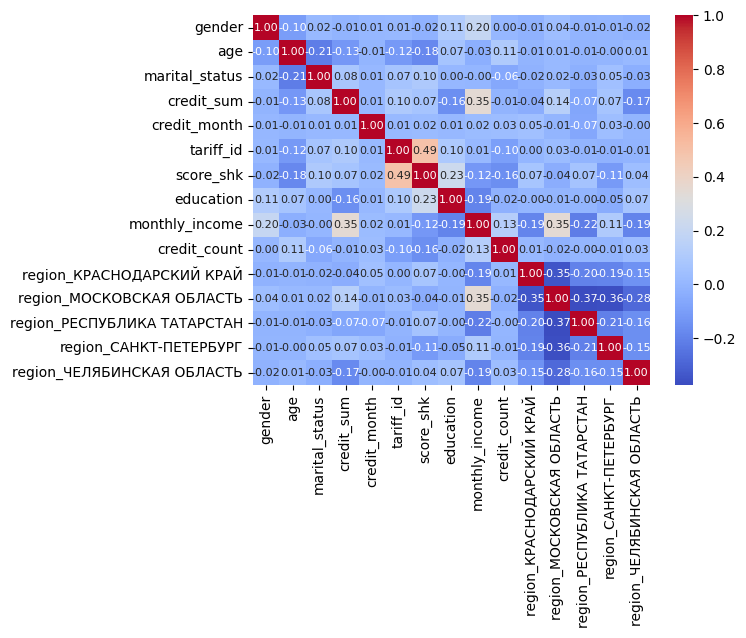

<Figure size 1200x1000 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_credit_train_df = credit_train_df.drop(columns=['client_id', 'job_position', 'overdue_credit_count', 'open_account_flg'])
correlation_matrix = correlation_credit_train_df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
plt.figure(figsize=(12, 10))
plt.show()


In [21]:
from scipy.stats import shapiro

normality_results = {}
for column in ['age', 'job_position', 'credit_sum', 'credit_month', 'overdue_credit_count', 'open_account_flg']:
    stat, p_value = shapiro(credit_train_df[column])
    normality_results[column] = p_value

# Вывод результатов
for column, p_value in normality_results.items():
    if p_value > 0.05:
        print(f"Столбец '{column}' распределен нормально (p-value = {p_value:.4f})")
    else:
        print(f"Столбец '{column}' не распределен нормально (p-value = {p_value:.4f})")

Столбец 'age' не распределен нормально (p-value = 0.0000)
Столбец 'job_position' распределен нормально (p-value = 1.0000)
Столбец 'credit_sum' не распределен нормально (p-value = 0.0000)
Столбец 'credit_month' не распределен нормально (p-value = 0.0000)
Столбец 'overdue_credit_count' распределен нормально (p-value = 1.0000)
Столбец 'open_account_flg' распределен нормально (p-value = 1.0000)


In [23]:
print("Финальный вид таблицы:")
credit_train_df.head()

Финальный вид таблицы:


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,monthly_income,credit_count,overdue_credit_count,open_account_flg,region_КРАСНОДАРСКИЙ КРАЙ,region_МОСКОВСКАЯ ОБЛАСТЬ,region_РЕСПУБЛИКА ТАТАРСТАН,region_САНКТ-ПЕТЕРБУРГ,region_ЧЕЛЯБИНСКАЯ ОБЛАСТЬ
7,8,0.0,0.150943,0.75,0.75,0.227807,0.212121,1.1,0.532554,0.25,0.058201,0.157895,0.0,0.0,False,True,False,False,False
10,11,1.0,0.150943,0.50,0.75,0.070015,0.333333,1.0,0.462837,0.75,0.032804,0.105263,0.0,0.0,False,False,False,True,False
16,17,1.0,0.339623,0.25,0.75,0.099553,0.212121,1.4,0.501961,0.75,0.047619,0.210526,0.0,0.0,True,False,False,False,False
29,30,1.0,0.245283,0.50,0.75,0.247503,0.212121,1.1,0.307946,0.25,0.052910,0.052632,0.0,0.0,True,False,False,False,False
30,31,0.0,0.150943,0.75,0.75,0.121157,0.212121,1.1,0.335454,0.25,0.021164,0.052632,0.0,0.0,False,True,False,False,False


### Выводы по 1 заданию
- Отфильтровали данные имеющие пропуски. Для данного случая пропусков было не так много и мы просто выкинули битые данные.
- Изучили способ фильтрации данных по выбросам. Для некоторых столбцов достаточно высокий уровень выбросов по межквартильному размаху.
- Построили коллерационную таблицу по которой видно, что имется слабая корреляция между ячейками tariff_id и score_shk, credit_summ и montly_income, montly_income и Московской областью.
- Провели тест на нормальность Шапиро-Уилка. Большинство столбцов не имеют нормального распределения.
- Масштабировали данные и закодировали столбец living_region используя one hot encoding.

### Задание 2

Есть данные, что тест на болезнь дает результат с вероятностью в 98%. Число больных в популяции у нас 1%. 
Вопрос - с какой вероятностью положительный тест будет положительным при случайном тестировании.

Анализ:
Для решения задачи будем использовать теорему Байеса. Нам требуется найти вероятность того, что человек болен при положительном тесте. Для этого нам требуется найти абсолютную вероятность положительного теста у зараженных (0.01 * 0.98) и разделить на общую вероятность положительного теста. Общая вероятность положительного теста это сумма  абсолютной вероятности положительного теста (вычислено на предидущем шаге) и абсолютной вероятности отрицательного теста при отсутствии болезни (1-0.98)*(1-0.01). 

Получаем: (0.01 * 0.98) / ((0.01 * 0.98) + (1-0.98)*(1-0.01)) = 0.33